# Create scatter plots

Export multiple attributes from a table and use the `pandas`, `matplotlib` and `seaborn` packages to compare material properties using 2D, 3D, and 4D scatter plots.

This example uses data from the *MaterialUniverse* table in the *MI Training* database.

## Get data from Granta MI

Connect to MI and specify a database and table.

In [14]:
from GRANTA_MIScriptingToolkit import granta as mpy
import GRANTA_MIScriptingToolkit as gdl

session = mpy.Session('http://azewacadmi1v1.win.ansys.com/mi_servicelayer/', autoLogon=True)
browseService = session.browseService
training_db = browseService.GetDatabases()
#('MI Training')
#training_db.set_unit_system('SI (Consistent)')
#material_universe = training_db.get_table('MaterialUniverse')

TypeError: __init__() got an unexpected keyword argument 'autoLogon'

Specify the records whose attributes you want to plot. In this case, all records in the table are used, but you can use other MI Scripting Toolkit methods to define a list of records (for example, `search_criterion()`).

In [ ]:
records = material_universe.all_records(include_generics=False, include_folders=False)

Bulk export the attributes you want to plot. (The attribute names are stored in a list for later use.)

In [ ]:
attributes = ['Designation', 'Base', 'Transparency', "Young's modulus", 'Density', 'Tensile strength',
              'Electrical resistivity']
material_universe.bulk_fetch(records, attributes=attributes)

## Process the data using `pandas`

### Build a DataFrame

A `pandas` DataFrame can be built from a `List` of `Dicts`, where each dictionary in the list corresponds to a separate row in the DataFrame. Each key-value pair in the `Dict` corresponds to a column and the cell value in that column,
respectively.

First generate the list of dictionaries, and then use this list to create a DataFrame. Here, we are using the `Record.id` property as the DataFrame index, but any column with a unique value for each record can be used.

In [ ]:
import pandas as pd

def get_attr_vals(r):
    return {mi_attr: r.attributes[mi_attr].value for mi_attr in attributes}

data = [{'id': r.id, **get_attr_vals(r)} for r in records]
df = pd.DataFrame(data).set_index('id')

Use the DataFrame `.head()` method to output the first few rows of the DataFrame and check the structure.

In [ ]:
df.head()

### Process any range data

A DataFrame cell can contain any data type we choose to store in it. However, plotting packages such as `matplotlib`
require numerical values to be in a standard format. Some MI Scripting Toolkit data types, such as
ranges represented as dictionaries, are not in that format and have to be processed before plotting.

Below, we define a `granta_mean` function which takes a single `dict` as input and calculates either the arithmetic or
geometric mean (depending on the signs of the input values).

In [6]:
import math

def granta_mean(value):
    if value is None:
        return None
    if 'high' not in value:
        return value['low']
    if 'low' not in value:
        return value['high']
    product = value['low'] * value['high']
    if product > 0:
        gm = math.sqrt(product)
        if value['low'] > 0:
            return gm
        else:
            return -gm
    else:
        return sum(value.values())/2

Apply the `granta_mean` function to each cell in the *Density*, *Young's modulus*, *Tensile strength*, and *Electrical
resistivity* columns. Store the results in a new DataFrame, and check the output to ensure the data processing worked as
expected.

In [7]:
df_processed = df[['Density', "Young's modulus", 'Tensile strength', 'Electrical resistivity']].applymap(granta_mean)
df_processed.head()

,Density,Young's modulus,Tensile strength,Electrical resistivity
id,,,,
8925,2514.875742,8.692341e+10,4.185224e+07,1.000000e+16
8926,2634.881402,8.597436e+10,3.945428e+07,1.000000e+16
8927,2549.509710,8.597674e+10,3.863832e+07,1.000000e+15
8928,2584.879107,6.594748e+10,2.938707e+07,1.000000e+15
8930,2754.886563,6.797875e+10,3.028944e+07,1.000000e+15


Since the columns now contain numeric data, we can use the `.describe()` method to provide some initial insights into
the distribution of values in the table. (This also confirms that the `granta_mean` function worked as expected.)

In [8]:
df_processed.describe()

,Density,Young's modulus,Tensile strength,Electrical resistivity
count,29.000000,2.900000e+01,2.900000e+01,2.900000e+01
mean,3056.118133,7.441616e+10,3.107848e+08,2.184037e+15
std,3201.106148,1.256091e+11,4.631297e+08,4.056391e+15
min,922.225549,7.509658e+05,8.289964e+06,4.298837e-08
25%,1184.905061,2.408319e+09,3.863832e+07,1.689970e-06
50%,1369.963508,1.308128e+10,6.816744e+07,4.000000e+13
75%,2799.839234,8.692341e+10,4.446234e+08,1.000000e+15
max,15597.115118,6.340347e+11,1.775671e+09,1.000000e+16


### Process any discrete or short text data

The columns *Transparency* and *Base* are based on discrete attributes, and so contain a list of values. In
this case, the discrete attributes are single-valued, so the DataFrame cells contain a single-valued list. 

Use the `DataFrame.applymap()` method and a `lambda` function to take the first value from each list in the specified columns, and append them as new columns in the new DataFrame.

In [9]:
df_processed[['Transparency', 'Base']] = df[['Transparency', 'Base']].applymap(lambda x: x[0])
df_processed.head()

,Density,Young's modulus,Tensile strength,Electrical resistivity,Transparency,Base
id,,,,,,
8925,2514.875742,8.692341e+10,4.185224e+07,1.000000e+16,Transparent,Oxide
8926,2634.881402,8.597436e+10,3.945428e+07,1.000000e+16,Transparent,Oxide
8927,2549.509710,8.597674e+10,3.863832e+07,1.000000e+15,Opaque,Oxide
8928,2584.879107,6.594748e+10,2.938707e+07,1.000000e+15,Opaque,Oxide
8930,2754.886563,6.797875e+10,3.028944e+07,1.000000e+15,Transparent,Oxide


Finally, the *Designation* column is based on a short-text attribute, which is represented as a string and can be
used as is. Single columns with valid Python identifiers (for example, no spaces) can be accessed as if they are
properties, but column creation always requires the use of square brackets.

In [10]:
df_processed['Designation'] = df.Designation
df_processed.head()

,Density,Young's modulus,Tensile strength,Electrical resistivity,Transparency,Base,Designation
id,,,,,,,
8925,2514.875742,8.692341e+10,4.185224e+07,1.000000e+16,Transparent,Oxide,1720
8926,2634.881402,8.597436e+10,3.945428e+07,1.000000e+16,Transparent,Oxide,1723
8927,2549.509710,8.597674e+10,3.863832e+07,1.000000e+15,Opaque,Oxide,9617
8928,2584.879107,6.594748e+10,2.938707e+07,1.000000e+15,Opaque,Oxide,6750
8930,2754.886563,6.797875e+10,3.028944e+07,1.000000e+15,Transparent,Oxide,7059


### Specify column units

`DataFrame` doesn't have a built-in method for specifying the units of a column. For this script, we will create a separate `dict` that provides a simple mapping between column headings and units.

In [11]:
units = {mi_attr: material_universe.attributes[mi_attr].unit for mi_attr in attributes
         if material_universe.attributes[mi_attr].unit}
units

{"Young's modulus": 'Pa',
 'Density': 'kg/m^3',
 'Tensile strength': 'Pa',
 'Electrical resistivity': 'ohm.m'}

## Create scatter plots using `pandas`

This snippet of code is optional, and is included to increase the size of all plots generated in this
notebook:

In [12]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 125

Use the built-in `.plot()` method to plot the data in your DataFrame.

By default, `.plot()` uses `matplotlib` to generate plots. Text wrapped in \\$dollar signs\\$ is processed as LaTeX-style math text.

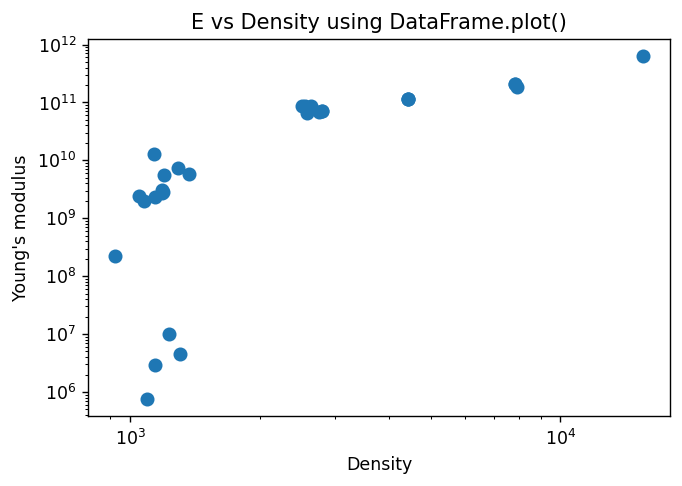

In [13]:
density_unit = units['Density']
ym_unit = units["Young's modulus"]
density_label = rf'Density / ${density_unit}$'
ym_label = rf'$E$ / ${ym_unit}$'

_ = df_processed.plot(x='Density',
                      y="Young's modulus",
                      kind='scatter',
                      s=50,
                      loglog=True,
                      xlabel=density_label,
                      ylabel=ym_label,
                      title = 'E vs Density using DataFrame.plot()')

## Create scatter plots with `matplotlib`

Alternatively, you can use `matplotlib` directly with the DataFrame as an input. For comparison, here is the same plot using `matplotlib`. The result is the same, but the figure and axes are first created with `plt.subplots()`, the axis scales and labels modified, and then the `ax.scatter()` method is used to create the plot itself. Finally, the top-level **plt** object is used to add a title.

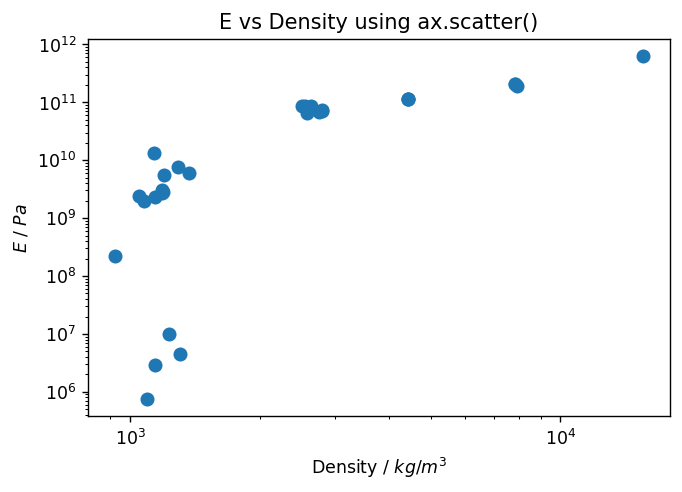

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel(ym_label)
ax.set_xlabel(density_label)
ax.scatter(data=df_processed, x='Density', y="Young's modulus", s=50)
_ = ax.set_title('E vs Density using ax.scatter()')

### Plotting data by category (discrete values)

Using `matplotlib` directly allows us to use the full power and flexibility of the package. For example, you can create a plot color-coded by the value of a discrete attribute by iteratively adding scatter plots to the same set of axes.

The simplest way to implement this is to use the `.groupby()` DataFrame method, which generates a set of **groupby**
objects. These behave like individual DataFrames, and can be plotted similarly to the previous example. `matplotlib` will
automatically increment the marker color for each new plot.

In the example below, the full `DataFrame` is separated into separate `groupby` objects that share the same *Base* value. These `DataFrame` rows are each plotted on their own scatter plot with a separate color. The marker is incremented manually
through a pre-defined list, which ensures accessibility for users with color vision deficiencies.

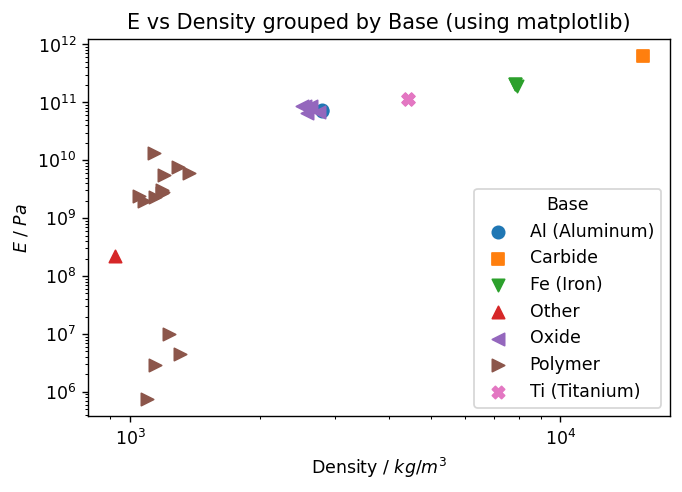

In [15]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel(ym_label)
ax.set_xlabel(density_label)

markers = ["o", "s", "v", "^", "<", ">", "X"]

for idx, (key, df) in enumerate(df_processed.groupby('Base')):
    marker = markers[idx]
    ax.scatter(data=df, x='Density', y="Young's modulus", label=key, s=50, marker=marker)
ax.set_title('E vs Density grouped by Base (using matplotlib)')
_ = plt.legend(title='Base')

### Creating a 3D scatter plot

The set-up of a 3D scatter plot is slightly different to the 2D examples above, because the z-axis must be added as a subplot. Use `figure()` and `add_subplot(projection='3d')` to create a 3D figure, then use an alternative syntax to plot the data (in previous plots, the data was added using DataFrame column names, whereas this example plots the arrays themselves).

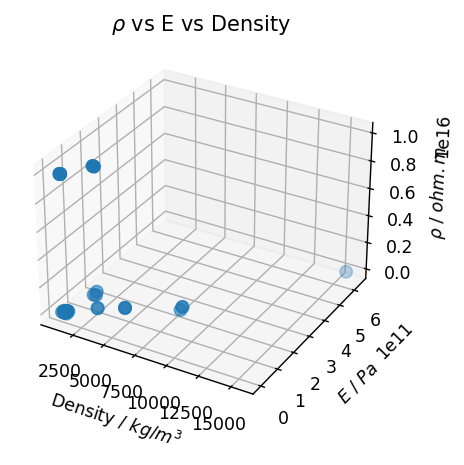

In [16]:
rho_unit = units['Electrical resistivity']
rho_label = rf'$\rho$ / ${rho_unit}$'

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_ylabel(ym_label)
ax.set_xlabel(density_label)
ax.set_zlabel(rho_label)

ax.scatter(df_processed['Density'], df_processed["Young's modulus"], df_processed['Electrical resistivity'], s=50)
_ = ax.set_title(r'$\rho$ vs E vs Density')

### Adding a continuous color axis to a 2D scatter plot

Add a continuous color axis using the `c` and `cmap` arguments to the `plot.scatter()` constructor. 

This example uses the optional `norm` argument to specify an alternative method of mapping numeric values to a color in the
colormap. The **color_norm** variable contains a logarithmic normalization which ensures color variation is used across all values of electrical resistivity.

The `viridis` colormap is perceptually uniform (monotonically increases in luminance) so is accessible to users with color vision deficiencies.

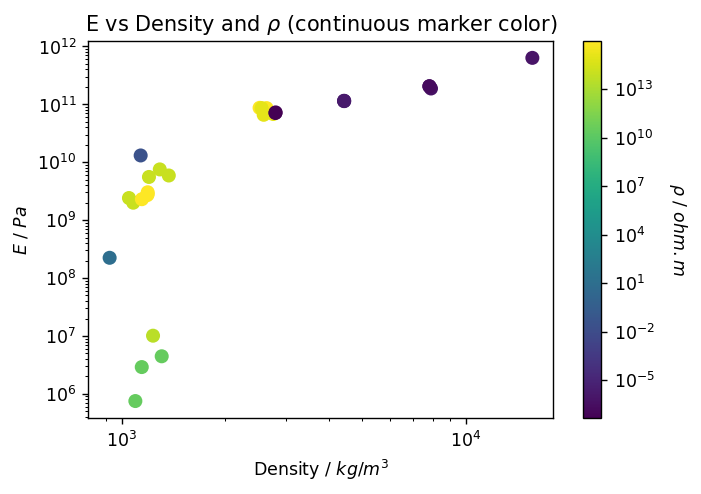

In [17]:
import matplotlib.colors as colors

rho_unit = units['Electrical resistivity']
rho_label = rf'$\rho$ / ${rho_unit}$'

fig, ax = plt.subplots()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel(ym_label)
ax.set_xlabel(density_label)

res_min = df_processed['Electrical resistivity'].min()
res_max = df_processed['Electrical resistivity'].max()
color_norm = colors.LogNorm(vmin=res_min, vmax=res_max)

sc = plt.scatter(data=df_processed,
                 x='Density',
                 y="Young's modulus",
                 c="Electrical resistivity",
                 s=50, cmap='viridis',
                 norm=color_norm)
cbar = plt.colorbar(sc)
cbar.set_label(rho_label, rotation=270, labelpad=20)
_ = ax.set_title(r'E vs Density and $\rho$ (continuous marker color)')

### Plotting data by category (binned point or range values)

For this plot, we first use `numpy.geomspace()` to define 5 logarithmically-spaced bins and `DataFrame.cut()` to map the
continuous *Electrical resistivity* values to those categories.

In [18]:
import numpy as np
min_value = df_processed['Electrical resistivity'].min()
max_value = df_processed['Electrical resistivity'].max()

# The number of values is calculated between the two values, and is one more than the required number of bins
spacing = np.geomspace(min_value, max_value, 6)

df_processed['Electrical resistivity (binned)'] = pd.cut(df_processed['Electrical resistivity'],
                                                         spacing,
                                                         labels=['Very low', 'Low', 'Medium', 'High', 'Very high'])
df_processed.head()

,Density,Young's modulus,Tensile strength,Electrical resistivity,Transparency,Base,Designation,Electrical resistivity (binned)
id,,,,,,,,
8925,2514.875742,8.692341e+10,4.185224e+07,1.000000e+16,Transparent,Oxide,1720,NaN
8926,2634.881402,8.597436e+10,3.945428e+07,1.000000e+16,Transparent,Oxide,1723,NaN
8927,2549.509710,8.597674e+10,3.863832e+07,1.000000e+15,Opaque,Oxide,9617,Very high
8928,2584.879107,6.594748e+10,2.938707e+07,1.000000e+15,Opaque,Oxide,6750,Very high
8930,2754.886563,6.797875e+10,3.028944e+07,1.000000e+15,Transparent,Oxide,7059,Very high


Then, we can use `.groupby()` to plot each bin with a different color and shape of marker. A `cycler.cycler` object specifies which colors will be used for each separate scatter plot.

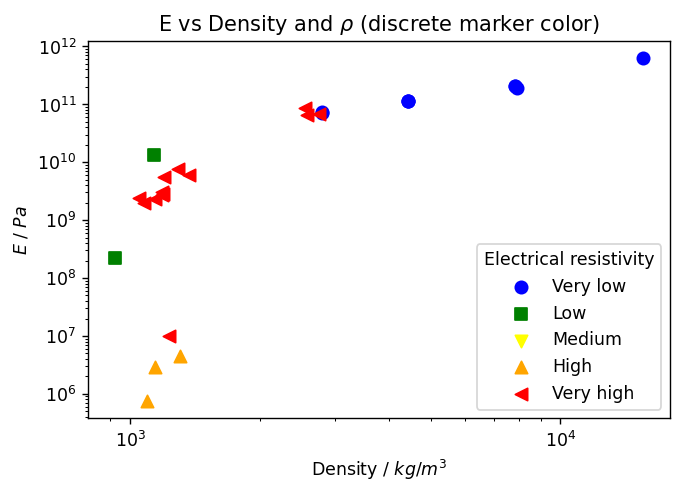

In [19]:
from cycler import cycler

fig, ax = plt.subplots()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel(ym_label)
ax.set_xlabel(density_label)

ax.set_prop_cycle(cycler('color', ['blue', 'green', 'yellow', 'orange', 'red']))

for idx, (key, df) in enumerate(df_processed.groupby('Electrical resistivity (binned)')):
    marker = markers[idx]
    ax.scatter(data=df, x='Density', y="Young's modulus", label=key, s=50, marker=marker)
plt.legend(title='Electrical resistivity', loc='lower right')
_ = ax.set_title(r'E vs Density and $\rho$ (discrete marker color)')

## Create scatter plots with `seaborn`

An alternative to using `matplotlib` directly is to use `seaborn`, a wrapper of `matplotlib` that aims to make it easier to create professional-looking plots. 

For example, here is the *E vs rho* plot grouped by 'Base' in `seaborn`. Note that the plot itself is defined in one line, and we can specify DataFrame columns to use for the marker `hue` and `style` with no additional steps. The legend is created automatically.

Text(0.5, 1.0, 'E vs Density grouped by Base (using seaborn)')

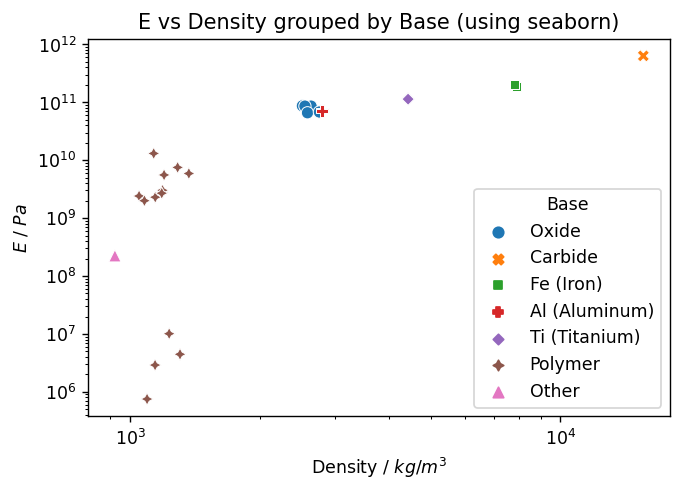

In [20]:
import seaborn as sns

ax = sns.scatterplot(data=df_processed, x="Density", y="Young's modulus", hue="Base", style="Base", s=50)
ax.set_xscale('log')
ax.set_xlabel(density_label)
ax.set_yscale('log')
ax.set_ylabel(ym_label)
ax.set_title('E vs Density grouped by Base (using seaborn)')

### Plotting in *n* dimensions (pair plots)

The `seaborn` package doesn't expose `matplotlib`'s 3D scatter plotting functionality. However, it can produce stacked (paired) plots of any dimensionality as required. The example below shows a comparison across 4 continuous dimensions. 

To avoid having to set the label of each axis, we've created a new DataFrame with the desired axis labels as column names. The labelling is then done automatically.

Although `sns.pairplot` doesn't have a `style` argument, you can provide a list of markers instead.

<Figure size 750x500 with 0 Axes>

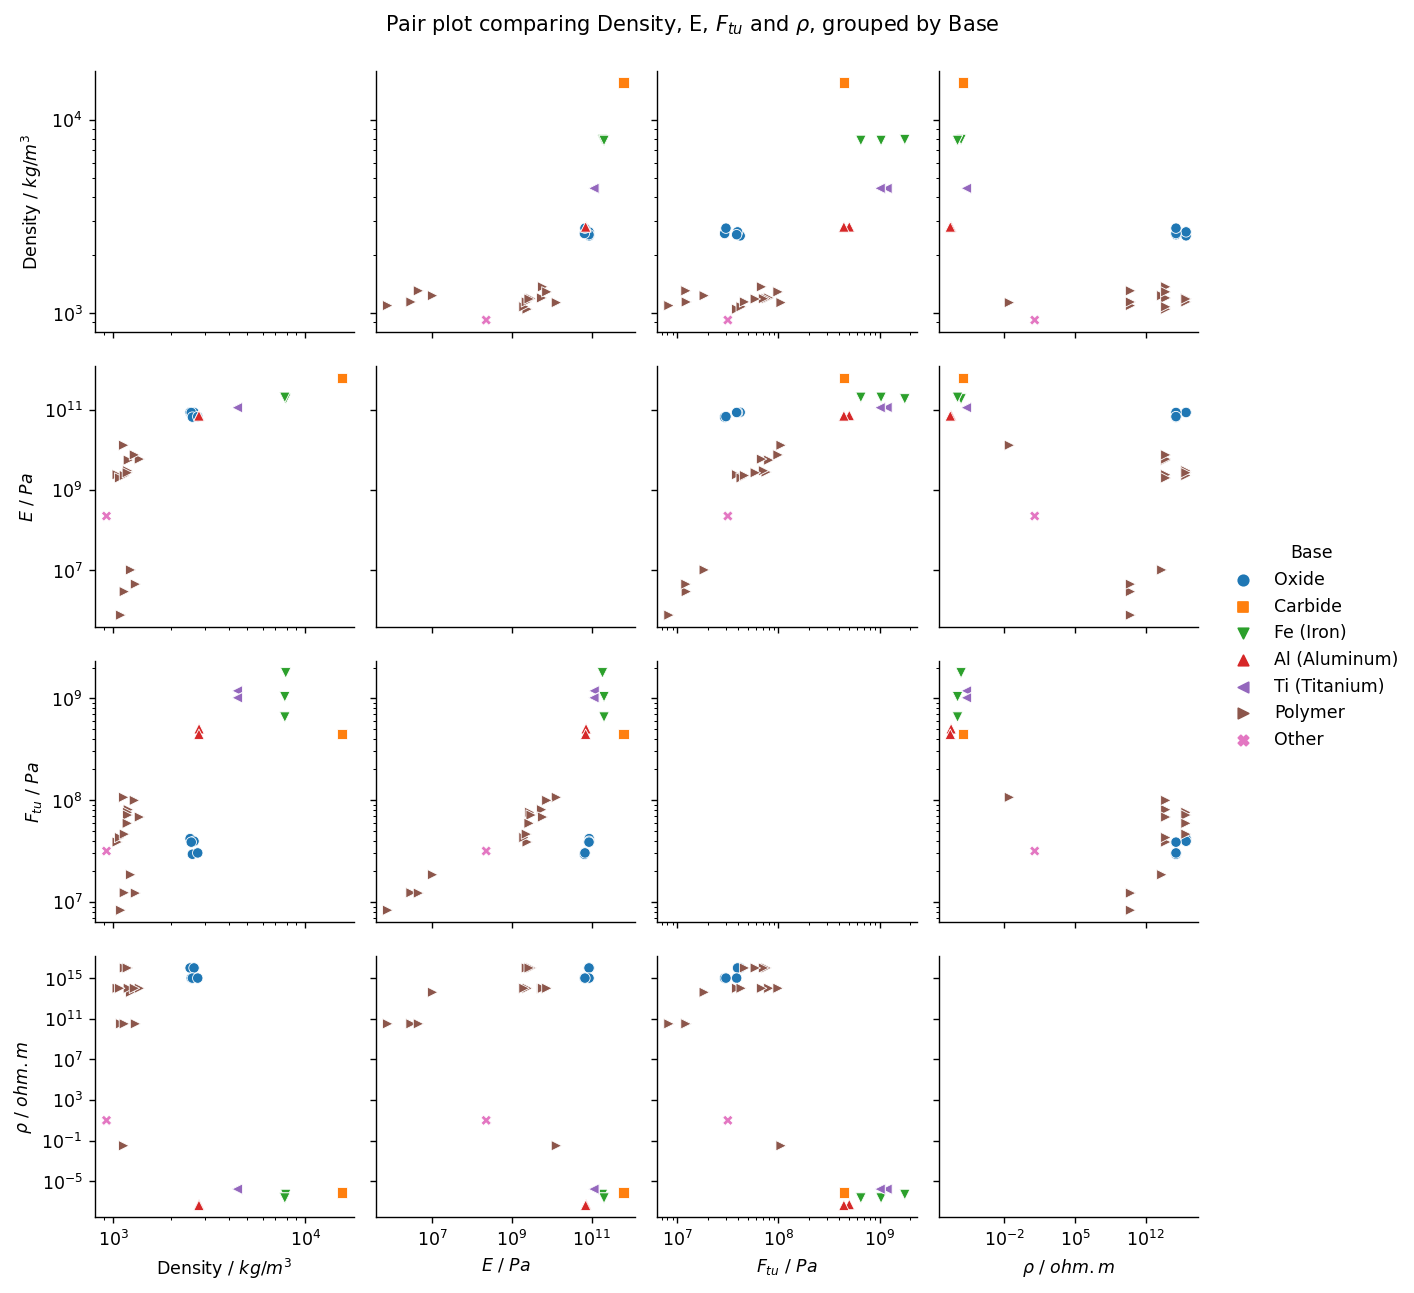

In [21]:
ftu_unit = units['Tensile strength']
ftu_label = rf'$F_{{tu}}$ / ${ftu_unit}$'

column_mapping = {'Density': density_label,
                  "Young's modulus": ym_label,
                  'Tensile strength': ftu_label,
                  'Electrical resistivity': rho_label}
df_pairplot = df_processed.rename(columns=column_mapping)

fig = plt.figure()
g = sns.pairplot(vars=[density_label, ym_label, ftu_label, rho_label],
                 data=df_pairplot,
                 hue="Base",
                 markers=markers,
                 diag_kind='None')

for i in range(len(g.axes)):
    for j in range(len(g.axes[i])):
        g.axes[i,j].set_xscale('log')
        g.axes[i,j].set_yscale('log')
_ = g.fig.suptitle(r'Pair plot comparing Density, E, $F_{{{tu}}}$ and $\rho$, grouped by Base', y=1.03)